# Chapter 2

Example project end to end.

<a id='toc'></a>
# TOC

1. [Accessing Real Data](#real_data)
2. [Used Data](#used_data)
3. Project
   1. [Looking at the big picture](#big_picture)
   2. [Get the data](#get_data)
   3. [Discover and visualize the data to gain insights](#visualize_data)
   4. [Prepare the data for Machine Learning algorithms](#prepare_data)
   5. [Select a model and train it](#train_model)
   6. [Fine-tune your model](#tune_model)
   7. [Present your solution](#solution)
   8. [Launch, monitor, and maintain your system](#launch)
   
4. Exercises
    1. [Exercise #1](#exercise_1)
    2. [Exercise #2](#exercise_2)

<a id='real_data'></a>
## 1. Accessing Real Data

**Popular open data repositories**

* [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/)
* [Kaggle datasets](https://www.kaggle.com/datasets)
* [Amazon’s AWS datasets](http://aws.amazon.com/fr/datasets/)

**Meta portals** (they list open data repositories)

* http://dataportals.org/
* http://opendatamonitor.eu/
* http://quandl.com/

**Other pages listing many popular open data repositories**

* [Wikipedia’s list of Machine Learning datasets](https://goo.gl/SJHN2k)
* [Quora.com question](http://goo.gl/zDR78y)
* [Datasets subreddit](https://www.reddit.com/r/datasets)

[Back to Table of Contents](#toc)

<a id='used_data'></a>
## 2. Used Data

California Housing Prices dataset from the StatLib repository<br />
<img src="images/C02_california_real_state_dataset.png" style="width: 500px" />

[Back to Table of Contents](#toc)

# 3. Project

<a id='big_picture'></a>
## 3.A Looking at the big picture

Build a model of housing prices in California using the California census data.

Metrics in this dataset:
* Population
* Median income
* Median housing price
* etc.

Block groups (or **'Districts'**):  smalles geographical unit for which there is sample data. Typically, with a population of 600 to 3000 people.

> The model **should learn** from this data and **be able to predict the median housing price in every district**, given all other metrics.

### Frame the problem
* **How do we expect to use and benefit from this model?**
* **What the current solution looks like?**

Always keep in mind which is the business goal. Building the model is not the end goal (usually). How do we expect to use and benefit from this model? Answering this is important because it will help to determine:
* How you frame the problem
* What algorithms you will select 
* What performance measure you will use to evaluate your model
* How much effort you should spend tweaking it

> In this case, the **model's ouput** (*a prediction of a district's median housing price*) will be combined with other signals to feed another Machine Learning system.

<br /><img src="images/C02_ml_pipeline.png" style="width: 600px" /><br />

The **next question to ask** is what the current solution looks like (if any). It will often give you a **reference performance**, as well as insights on how to solve the problem. Currently, this is done manually and it is very time consuming. **These manual estimates are off by more than 10%.**

With all these information, we are **ready to start designing** the system.

For now, we know that:

* It is clearly a typical **supervised learning** task since you are *given labeled training examples* (each instance comes with the expected output, i.e., the district’s median housing price). 
* It is also a typical **regression task**, since you are asked to *predict a value*. More specifically, this is a multivariate regression problem since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.). 
* There is **no continuous flow of data** coming in the system
* There is **no particular need to adjust to changing data rapidly**
* The **data is small enough** to fit in memory, so plain batch learning should do just fine

### Select a performance Measure

A typical performance measure for regression problems is the Root Mean Square Error (RMSE)

$$RMSE(X,h) = \sqrt{{1 \over m}{\sum_{i=1}^{m}(h(x^{(i)})-y^{(i)})^2}}$$

* m is the number of instances in the dataset you are measuring the RMSE on.
  * For example, if you are evaluating the RMSE on a validation set of 2,000 districts, then m = 2,000.
* x(i) is a vector of all the feature values (excluding the label) of the i-th instance in the dataset, and y(i) is its label (the desired output value for that instance).
  * For example, if the first district in the dataset is located at longitude –118.29°, latitude 33.91°, and it has 1,416 inhabitants with a median income of \$38,372, and the median house value is \$156,400 (ignoring the other features for now), then:<br /><br />
$$X^{(1)} = \left( \begin{matrix} -118.29 \\ 33.91 \\ 1,416 \\38,372 \end{matrix} \right) $$
<br />and:
$$y^{(1)} = 156,400$$
<br /><br />
* **X** is a matrix containing all the feature values (excluding labels) of all instances in the dataset. There is one row per instance and the i-th row is equal to the transpose.
  * For example, if the first district is as just described, then the matrix X looks like this:
<br /><br />
$$X=\left( \begin{matrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(1999)})^T \\ (x^{(2000)})^T \end{matrix} \right)  = \left( \begin{matrix} -118.29 & 33.93 & 1,416 & 38,372 \\ \vdots & \vdots & \vdots & \vdots \end{matrix} \right)$$<br />
* **h** is your system’s **prediction function**, also called a hypothesis. When your system is given an instance’s feature vector x(i), it outputs a predicted value ŷ(i) = h(x(i)) for that instance (ŷ is pronounced “y-hat”).
  * For example, if your system predicts that the median housing price in the first district is \$158,400, then 
ŷ(1) = h(x(1)) = 158,400. The prediction error for this district is ŷ(1) – y(1) = 2,000.
* **RMSE(X,h)** is the cost function measured on the set of examples using your hypothesis h.
<br /><br />

In a context were outliers are rare (like in a bell-shaped curve), **RMSE** performs very well. In cases where there are many outlier, you would like to check [the Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error)

### Check the assumptions

Good practice to list and verify the assumptions that were made so far in order to cath serious issues early on.

In this example, the district prices that the system is going to output are going to be fed into another ML system. Does this system convert the prices into categories (cheap, mediaum, expensive) and then use those categories instead of prices? In that case, then the problem should have been framed as a classification task, not a regression task.

For this example, the downstream ML system needs the actual prices, not categories.

[Back to Table of Contents](#toc)

<a id="3b_get_data"></a>
## 3.B Get the data

If you are not using docker and prefer to install the system locally, please refer to the [installation instructions](./pdf/installation_instructions.pdf) within the PDF folder.

Inside the *datasets* folder you can find the corresponding *housing* dataset for this exercise. The tgz folder contains the compressed version of housing.csv. 

The following code loads the data using Pandas. The load_housing_data() function returns a Pandas DataFrame object containing all the data:

In [1]:
import os
import pandas as pd

HOUSING_PATH = os.path.join("datasets", "housing")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(HOUSING_PATH, "housing.csv")
    return pd.read_csv(csv_path)

### Analyze data structure
#### Head and Info: Quick inspection of the data  
Take a look at the top five rows using the DataFrame's **head()** method:

In [2]:
housing = load_housing_data()
housing.head(30)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Each row represents one district. There are 10 attributes.

The **info()** method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is **fairly small by Machine Learning standards**.

The total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later.
All attributes are numerical, except the ocean_proximity field. Its type is object, so it could hold any kind of Python object (since data was loaded from a CSV file, it must be a text attribute). 

#### Value_counts: How many categories?
When you looked at the top five rows, you probably noticed that the values in the ocean_proximity column were repetitive, which means that it is probably a categorical attribute. You can find out what categories exist and how many districts belong to each category by using the value_counts() method:

In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### Describe: Summary of numerical attributes
The **describe()** method shows a summary of the numerical attributes

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


* Count, mean, min and max rows are self-explanatory. 
* **Null values** are ignored
* Std row shows the standard deviation (measures how dispersed the values are)
* 25%, 50% and 75% are the percentiles (or 1st quartile, median, and the 3rd quartile)

#### Histogram: How is my data
Another way to get a feel of the data we are dealing with is to plot a histogram for each numerical attribute. Calling the hist() method on the whole dataset will plot a histogram for each numerical attribute.

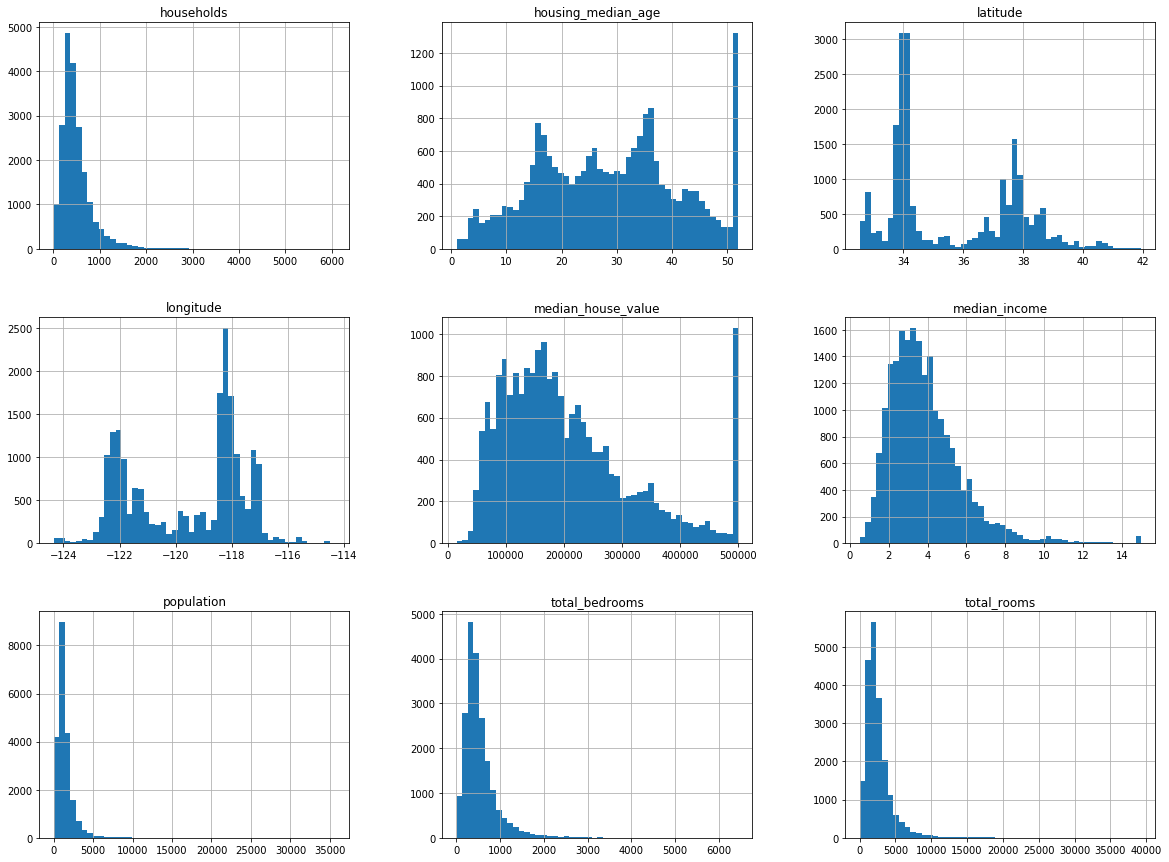

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

**Note**
The hist() method relies on Matplotlib, which in turn relies on a user-specified graphical backend to draw on your screen. So before you can plot anything, you need to specify which backend Matplotlib should use. The simplest option is to use Jupyter’s magic command %matplotlib inline. This tells Jupyter to set up Matplotlib so it uses Jupyter’s own backend.

A few details about the histograms:

- The median income attribute does not look like it is expressed in US dollars (USD).  In this case, the data has been preprocessed and has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. 
  * Working with preprocessed attributes is common in Machine Learning.
  
- The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels. If we know that predictions need to be precise even after USD 500,000, there are two options:
  * Collect proper labels for the districts whose lables were capped
  * Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond USD 500,000).
- These attributes have very different scales.
- Many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

### Create a Test Set

Creating a test set is theoretically quite simple: just pick some instances randomly, **typically 20% of the dataset**, and set them aside

Several problems:
* I want to **get the same test set** always, no matter how many times I grab a dataset and split it
* If I **update the dataset with more data**, the former training data might become test data in the new test set.

To ensure that after refreshing the set, we select the same test set, we can use a hash function to calculate the hash of each instance's identifier, keep only the last byte of the hash, and select the lower 20% (<=51, of 256 values). 
* This ensure that the new test set will not contain any instance that was previously in the training set.

Implementation:

In [7]:
import numpy as np
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Our housing dataset does not contain an identifier column. Let's use the row index as ID:

In [8]:
housing_with_id = housing.reset_index()   # adds an `index` column
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features.
* There is a random_state parameter that allows you to set the random generator seed
* You can pass it multiple datasets with an identical number of rows, and it will split them on the same indices

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias.

**Stratified sampling**: the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

Suppose that the **median income** is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. 
Since the median income is a *continuous numerical attribute*, you first **need to create an income category attribute**. 

Based on the histogram, most median income values are clustered around $20,000–$50,000, but some median incomes go far beyond $60,000. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. 

The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:

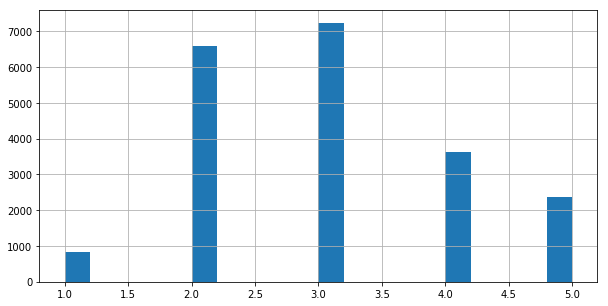

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist(bins=20, figsize=(10,5))
plt.show()

Now we can do stratified sampling based on the income category using *Scikit-Learn’s StratifiedShuffleSplit* class

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Now you should remove the income_cat attribute so the data is back to its original state:

In [12]:
strat_train_set.head()
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Now we have generated a test set, critical part of a Machine Learning project! The next step is exploring the data.

[Back to Table of Contents](#toc)

<a id="visualize_data"></a>
## 3.C Discover and Visualize the Data to Gain Insights

Until now we just got a general understanding of the kind of data we have. Our new goal now is to go a little bit more in depth.

Let’s create a copy so you can play with it without harming the training set, as we are going to work directly with it:

In [13]:
housing = strat_train_set.copy()

### Visualizing Geo Data

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data

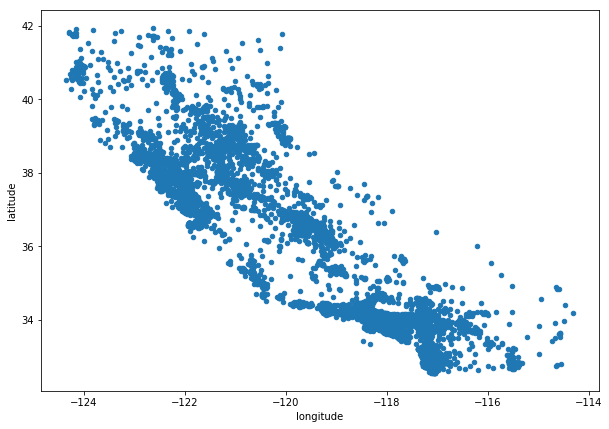

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude",  figsize=(10,7))

Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points 

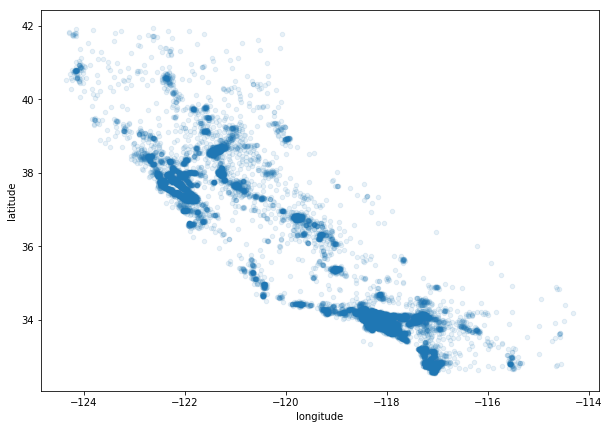

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10,7))

In the following picture, we want to relate the housing prices with the district's population (radios of each circle, option s) and the price (in color, option c). We will use a predifined color map (option cmap) calle *jet*, which ranges from blue to red (from low to high prices).

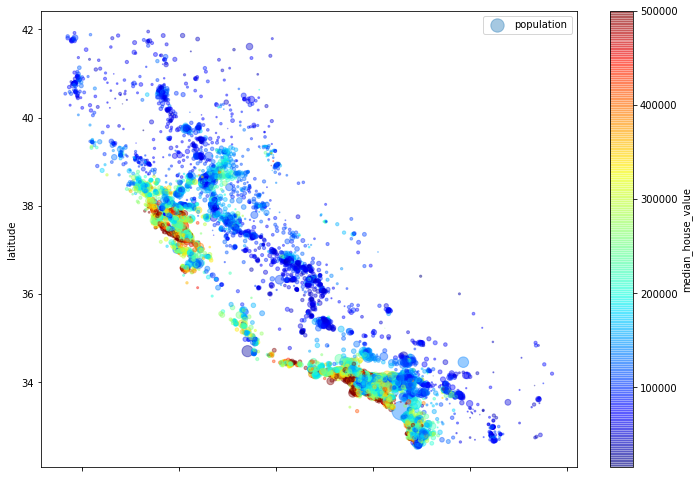

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(12,8.4),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

### Looking for Correlations

As the dataset is not too large, we can easily compute the [standard correlation coefficient (Pearson's r)](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between every pair of attribute using the **corr()** method:

In [17]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north).

Another way to check for correlation between attributes is to use Pandas’ scatter_matrix function, which plots every numerical attribute against every other numerical attribute. Let’s just focus on a few promising attributes that seem most correlated with the median housing value:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64e5c5ad68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6502fed2b0>]], dtype=object)

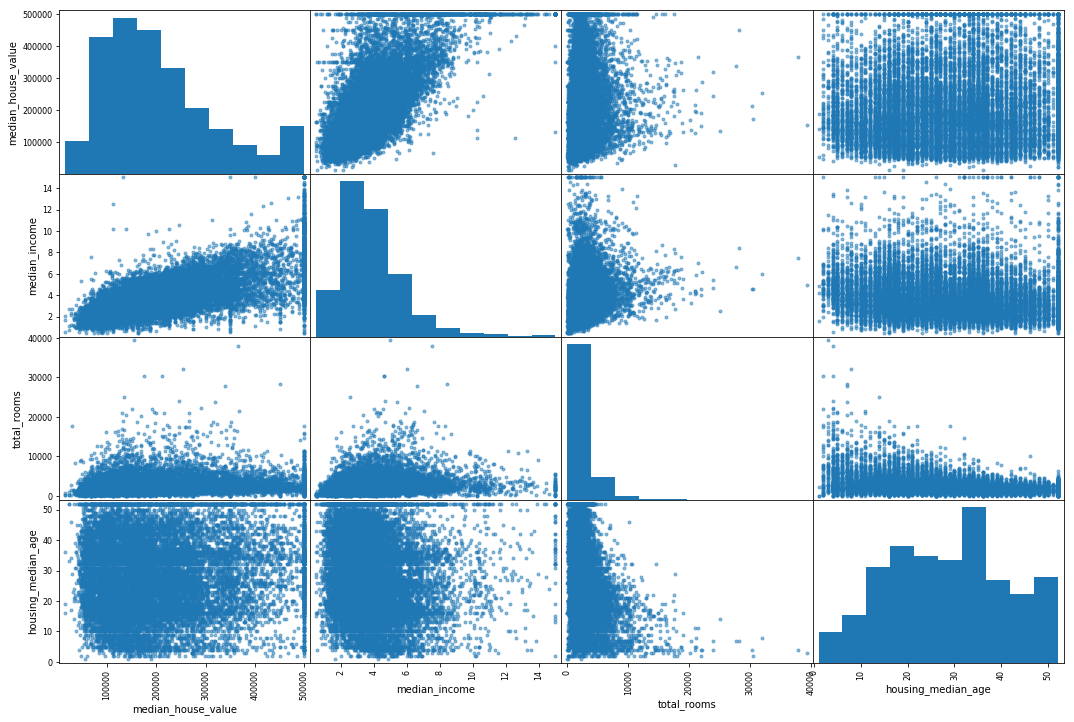

In [18]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(18, 12))

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot.

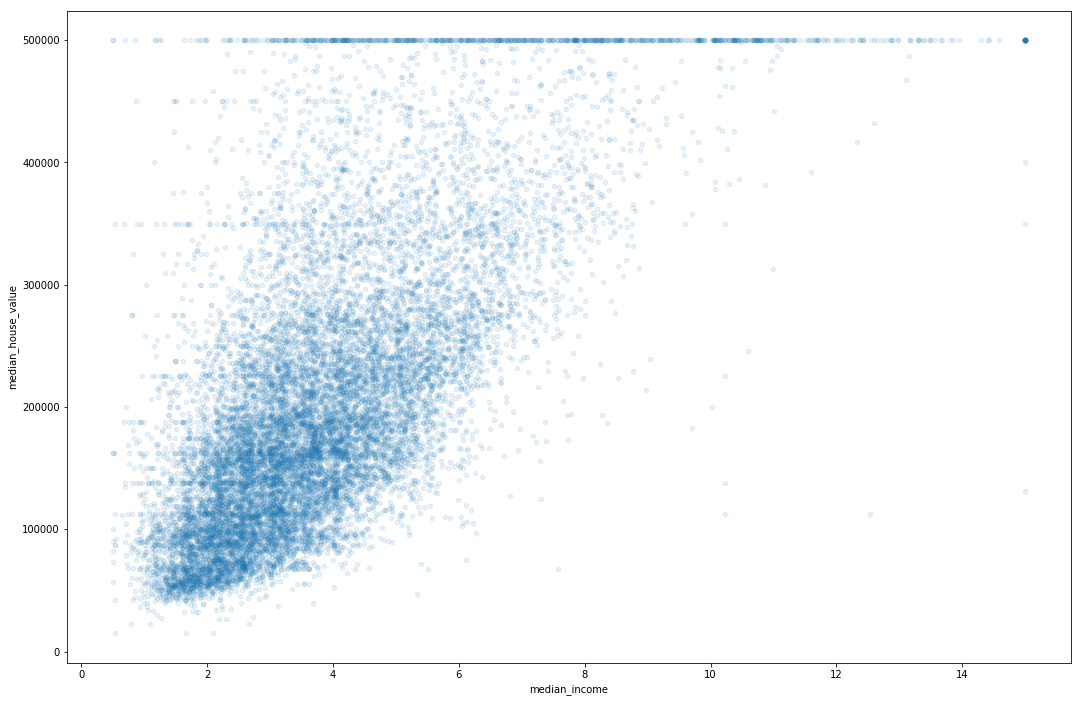

In [19]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(18, 12))

This plot reveals a few things. 

* The correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed
* The price cap that we noticed earlier is clearly visible as a horizontal line at \$500,000
   * But this plot reveals other less obvious straight lines: a horizontal line around \$450,000 
   * Another around \$350,000
   * Perhaps one around \$220,000
   * and a few more below that

You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

### Experimenting with Attribute Combinations

* In the previous section we have explored the data and gain insights. 
  * A few **data quirks** were identified so we could clean up data before feeding it to a Machine Learning algorithm.
  * Some interested **correlations** between attributes were found.
  * Some attributes have a **tail-heavy** distribution, so it would be necessary to transform them

One last thing to do before preparing the data for Machine Learning algorithms is to try out various attribute combinations.

For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of **rooms per household**. 

Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the **number of rooms**. 

And the **population per household** also seems like an interesting attribute combination to look at. 

In [20]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Let's look at the correlation matrix again:

In [21]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new **bedrooms_per_room attribute** is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently **houses with a lower bedroom/room ratio tend to be more expensive**. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

[Back to Table of Contents](#toc)

<a id='prepare_data'></a>
## 3.D Prepare the data for Machine Learning algorithms.

It’s time to prepare the data for your Machine Learning algorithms. We are going to write several function so:

* We can reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).
* We will gradually build a library of transformation functions that you can reuse in future projects.
* We can use these functions in your live system to transform the new data before feeding it to your algorithms.
* We will be able to easily try various transformations and see which combination of transformations works best.

Let’s revert to a clean training set (by copying strat_train_set once again), and let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that drop() creates a copy of the data and does not affect strat_train_set)


In [22]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data cleaning

We cannot work with missing features, so let's create function to take care of them (for example: total_bedrooms). There are three options:

* Get rid of the corresponding districts.
* Get rid of the whole attribute.
* Set the values to some value (zero, the mean, the median, etc.)

You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna() methods:

```
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

If you choose option 3, you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: **Imputer**.

* First, you need to create an Imputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

```
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
```

* Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity:

```
housing_num = housing.drop("ocean_proximity", axis=1)
```

* Now you can fit the imputer instance to the training data using the fit() method:

```
imputer.fit(housing_num)
```

* The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

```
>>> imputer.statistics_
array([ -118.51 , 34.26 , 29. , 2119.5 , 433. , 1164. , 408. , 3.5409])
>>> housing_num.median().values
array([ -118.51 , 34.26 , 29. , 2119.5 , 433. , 1164. , 408. , 3.5409])
```

Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

```
X = imputer.transform(housing_num)
```

The result is a plain Numpy array containing the transformed features. If you want to put it back into a Pandas DataFrame, it’s simple:

```
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
```

In [23]:
#from sklearn.preprocessing import Imputer#from sk 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, missing_values='NaN', strategy='median', verbose=0)

In [ ]:
imputer.statistics_

In [ ]:
housing_num.median().values

In [ ]:
X = imputer.transform(housing_num)

### Handling Text and Categorical Attributes

Earlier we left out the categorical attribute ocean_proximity because it is a text attribute so we cannot compute its median:

In [ ]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these categories from text to numbers. For this, we can use Pandas’ factorize() method which maps each category to a different integer:

In [ ]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

housing_cat_encoded is now purely numerical. The factorize() method also returns the list of categories (“<1H OCEAN” was mapped to 0, “NEAR OCEAN” was mapped to 1, etc.):

In [ ]:
housing_categories

This representation has an issue: ML algorithms will assume that two nearby values are more similar than two distant values. This is not the case: categories 0 and 4('<1H OCEAN', 'ISLAND') are more similar than categories 0 and 2 ('<1H OCEAN', 'INLAND').

The solution is to create one binary attribute per category
* One attribute equal to 1 when the category is '<1H OCEAN' (and 0 otherwise)
* Another attribute equal to 1 when the category is 'NEAR OCEAN' (and 0 otherwise)
* and so on

This is called **one-hot-encoding**, because only one attibute will be equal to 1 (hot) while the others will be 0 (cold).

Scikit-Learn provides a **OneHotEncoder encoder** to convert integer categorical values into one-hot vectors. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

* **fit_transform()** expects a 2D array, but housing_cat_encoded is a 1D array, so we need to reshape it
* the output is a SciPy **sparse matrix**, instead of a NumPy array. Very useful when you have categorical attributes with thousands of categories. 
  * After one-hot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for a single 1 per row.
  * Instead a sparse matrix only stores the location of the nonzero elements. 
  * You can use it mostly like a normal 2D array but if you really want to convert it to a (dense) NumPy array, just call the toarray() method:

In [ ]:
housing_cat_1hot.toarray()

You can apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot using the **CategoricalEncoder** class. It is part of Scikit-Learn 0.20-dev0 

In [ ]:
from sklearn.preprocessing import CategoricalEncoder
cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

By default, the CategoricalEncoder outputs a sparse matrix, but you can set the encoding to "onehot-dense" if you prefer a dense matrix:

In [ ]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

### Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. 

You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need is to create a class and implement three methods: 
* fit() (returning self)
* transform()
* fit_transform(). 
    * You can get the last one for free by simply adding TransformerMixin as a base class. 
    
Also, if you add BaseEstimator as a base class (and avoid *args and \**kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning. 

For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, **add_bedrooms_per_room**, set to True by default (it is often helpful to provide sensible defaults). 

This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. 

More generally, you can add a hyperparameter to **gate any data preparation step** that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

### Feature Scaling

Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

Two methods to get all attributes to have the same scale:
    * mix-max scaling
    * standardization

- **Min-max scaling**
  * Values are shifted and rescaled so that they end up ranging from 0 to 1. 
  * Subtract the min value and dividing by (max - min). 

Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason.

- **Standardization**
  * First, substracts the mean value (standardized values has 0 mean)
  * Second, it divides by the variance (resulting distribution has unit variance)

Unlike min-max scaling, standardization does not bound values to a specific range (problematic for some algorithms). However, it is less affected by outliers.

Scikit-Learn provides a transformer called StandardScaler for standardization.

*Note*: As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). 

### Transformation Pipelines

There are many data transformation steps that need to be executed in the right order. 

Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

```
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
```

The **Pipeline constructor** takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be **transformers** (i.e., they must have a fit_transform() method). The names can be anything you like (as long as they don’t contain double underscores “__”).

When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the fit() method.

The pipeline exposes the same methods as the final estimator. 

*In this example, the last estimator is a StandardScaler, which is a transformer, so the pipeline has a transform() method that applies all the transforms to the data in sequence (it also has a fit_transform method that we could have used instead of calling fit() and then transform()).*


Now it would be nice if we could feed a Pandas DataFrame containing **non-numerical columns** directly into our pipeline, instead of having to first manually extract the numerical columns into a NumPy array. There is nothing in Scikit-Learn to handle Pandas DataFrames, but we can write a custom transformer for this task:

```
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
```

**DataFrameSelector** will transform the data by:
* selecting the desired attributes
* dropping the rest
* and converting the resulting DataFrame to a NumPy array

With this, you can easily write a pipeline that will take a Pandas DataFrame and **handle only the numerical values**: the pipeline would just start with a DataFrameSelector to pick only the numerical attributes, followed by the other preprocessing steps we discussed earlier. 

And you can just as easily write **another pipeline for the categorical attributes** as well by simply selecting the categorical attributes using a DataFrameSelector and then applying a CategoricalEncoder.


```
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])
```

In order to join these two pipelines into a single pipeline, Scikit-Learn’s **FeatureUnion class**. 

You give it a **list of transformers** (which can be entire transformer pipelines). When its transform() method is called:
* it runs each transformer’s transform() method in parallel, 
* waits for their output
* and then concatenates them and returns the result (and of course calling its fit() method calls each transformer’s fit() method). 

A full pipeline handling both numerical and categorical attributes may look like this:

```
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
```

If we want to run the whole pipeline:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('simple_imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared.shape

[Back to Table of Contents](#toc)

<a id='train_model'></a>
## 3.E Select and Train a Model

After all the previous steps, we can start training our model. Let's first train a **Linear Regression model**:

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

Now the model is already created. Let's try it out on a few instances from the training set:

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

It seems to work, although predictions are not exactly accurate.  Which is the RMSE on the whole training set? We can use Scikit-Learn's mena_squared_error function

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

Clearly it is not a great score: most districts’ median_housing_values range between \$120,000 and \$265,000, so a typical prediction error of \$68,628 is not very satisfying. 

This is an example of a **model underfitting the training data**. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

The main ways to fix underfitting are 
* to select a more powerful model
* to feed the training algorithm with better features
* or to reduce the constraints on the model

In this example we do not have constraints (it is **not a regularized model**) so we can discard the last option.

### Selecting a more complex Model

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

There is no error... What? It is much more likely that the model has badly **overfit the data**. How to be sure? We don't want to touch the test set until we are ready to launch a model, so you need to use part of the training set for training, and part for model validation. 

#### Better evaluation using Cross-Validation

One way to evaluate the Decision Tree model would be to use the **train_test_split** function to split the training set into a **smaller training set** and a **validation set**, then train your models against the smaller training set and evaluate them against the validation set. 

A great alternative is to use **Scikit-Learn’s cross-validation** feature. 

The following code performs **K-fold cross-validation**: 
* it randomly splits the training set into 10 distinct subsets called folds
* then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. 

The result is an array containing the 10 evaluation scores:

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Scikit-Learn cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes -scores before calculating the square root.

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
          
display_scores(tree_rmse_scores)

Based on this, the **Decission Tree** doesn't look as good as earlier. It performs worse than the **Linear Regression** model, actually. 

Cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). 

The **Decision Tree** has a **score** of approximately **71372**, generally **±3318**. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

If we compute the same scores for the Linear Regression model:

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

It is clear than the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model. Let's try **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)

In [ ]:
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Random Forests look very promising. However, note that the **score on the training set (forest_rmse)** is still much **lower than on the validation sets (forest_rmse_scores)**. This means that the model is still **overfitting** the training set. 

Possible solutions for overfitting are:
* to simplify the model
* constrain it (i.e., regularize it)
* or get a lot more training data. 

You should try out many other models from various categories of Machine Learning algorithms (several Support Vector Machines with different kernels, possibly a neural network, etc.), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

[Back to Table of Contents](#toc)

<a id='tune_model'></a>
## 3.F Fine-Tune the Model

Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them. Let’s look at a few ways you can do that.

#### Grid Search

You can always manually play with the hyperparameters, looking for the perfect combination. Or you can use Scikit-Learn’s GridSearchCV to search for you. 

All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. 

For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

**param_grid** tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values specified in the first dict, then try all 2 × 3 = 6 combinations of hyperparameter values in the second dict, but this time with the bootstrap hyperparameter set to False instead of True (which is the default value for this hyperparameter).

All in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor hyperparameter values, and it will train each model five times (since we are using five-fold cross validation). 

In other words, all in all, there will be 18 × 5 = 90 rounds of training! It may take quite a long time, but when it is done you can get the best combination of parameters like this:

In [ ]:
grid_search.best_params_

You can also get the best estimator directly

In [ ]:
grid_search.best_estimator_

If GridSearchCV is initialized with refit=True (which is the default), then once it finds the best estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its performance.

And of course the evaluation scores are also available:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In this example, we obtain the best solution by setting the max_features hyperparameter to 6, and the n_estimators hyperparameter to 50. The RMSE score for this combination is 49,508, which is slightly better than the score you got earlier using the default hyperparameter values.

Congratulations!!


#### Randomized Search

The **grid search approach** is fine when you are exploring relatively **few combinations**, like in the previous example, but when the hyperparameter search space is **large**, it is often preferable to use **RandomizedSearchCV** instead. 

This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it **evaluates a given number of random combinations** by selecting a random value for each hyperparameter at every iteration. 

This approach has two main benefits:

* If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).

* You have more control over the computing budget you want to allocate to hyperparameter search, simply by setting the number of iterations.

#### Ensemble Methods

Another way to fine-tune your system is to try to combine the models that perform best. The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors.

#### Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

Let’s display these importance scores next to their corresponding attribute names:

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.).

#### Evaluate Your System on the Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform()!), and evaluate the final model on the test set:

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

The performance will usually be slightly worse than what you measured using cross-validation if you did a lot of hyperparameter tuning (because your system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

[Back to Table of Contents](#toc)

<a id='solution'></a>
## 3.G Present the Solution

Now comes the project prelaunch phase: you need to present your solution (highlighting what you have learned, what worked and what did not, what assumptions were made, and what your system’s limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g., “the median income is the number one predictor of housing prices”).

[Back to Table of Contents](#toc)

<a id='launch'></a>
## 3.H Launch, Monitor, and Maintain Your System

Perfect, you got approval to launch! You need to get your solution ready for production, in particular by plugging the production input data sources into your system and writing tests.

* Need to **write monitoring code** to check your system’s live performance at regular intervals and trigger alerts when it drops. 
  * This is important to catch not only sudden breakage, but also performance degradation. This is quite common because models tend to “rot” as data evolves over time, unless the models are regularly trained on fresh data.
  * Evaluating your system’s performance will require sampling the system’s predictions and evaluating them. This will generally require a human analysis. 
  
* Make sure to evaluate the system’s **input data quality**. 
  * Sometimes performance will degrade slightly because of a poor quality signal (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale), but it may take a while before your system’s performance degrades enough to trigger an alert.
  * Monitoring the inputs is particularly important for online learning systems.

* **Train** your models on a regular basis using fresh data. 
  * Automate this process as much as possible. If you don’t, you are very likely to refresh your model only every six months (at best), and your system’s performance may fluctuate severely over time. 
  * If your system is an online learning system, you should make sure you save snapshots of its state at regular intervals so you can easily roll back to a previously working state.
  
[Back to Table of Contents](#toc)

<a id='exercise_1'></a>
# Exercise 1: Solution

```
from sklearn.svm import SVR

svr_reg = SVR(kernel='rbf', gamma='auto', C=1.0)
svr_reg.fit(housing_prepared, housing_labels)
housing_predictions = svr_reg.predict(housing_prepared)
from sklearn.metrics import mean_squared_error
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse
```

[Back to Table of Contents](#toc)

<a id='exercise_2'></a>
# Exercise 2: Solution

```
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False]}

forest_reg = RandomForestRegressor()

random_search = RandomizedSearchCV(forest_reg, param_dist, cv=5,
                           scoring='neg_mean_squared_error')

random_search.fit(housing_prepared, housing_labels)

random_search.best_params_

random_search.best_estimator_

rsres = random_search.cv_results_
for mean_score, params in zip(rsres["mean_test_score"], rsres["params"]):
    print(np.sqrt(-mean_score), params)
```

[Back to Table of Contents](#toc)